In [ ]:
# Enze Xu
# Github: https://github.com/EnzeXu/PINN
# git clone https://github.com/EnzeXu/PINN.git

import torch
import time
import random
import argparse
import math
import os
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
from collections import OrderedDict
from torchsummary import summary
from torch.backends import cudnn
from mpl_toolkits.mplot3d import Axes3D

from google.colab import drive
import sys
drive.mount("/content/drive")

main_path = '/content/drive/My Drive/Workspace/PINN/' # ENZE marked: you need to change your main_path if it's not here
sys.path.append(main_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install pyDOE
from pyDOE import lhs

In [ ]:
class ConfigULEND:
    T = 20.0
    T_unit = 0.001
    N = int(T / T_unit)
    # X_start = -2.247
    # Y_start = 2.247
    # Z_start = 11
    X_start = None
    Y_start = None
    Z_start = None

    X_random_range = [-10.0, 10.0]
    Y_random_range = [-10.0, 10.0]
    Z_random_range = [10.0, 30.0]

    mu = 0.1
    omega = 1.0
    A = -0.1
    lam = 10.0
    ub = T
    lb = 0.0


class SimpleNetworkULEND(nn.Module):
    def __init__(self, config, random_seed=None):
        super(SimpleNetworkULEND, self).__init__()
        if not random_seed:
            random_seed = 0
        self.setup_seed(random_seed)
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.x, self.y0, self.t0 = None, None, None
        self.generate_x()
        # self.optimizer = optim.LBFGS(self.parameters(), lr=0.001, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100, line_search_fn=None)
        self.initial_start()
        self.model_name = "SimpleNetworkULEND"
        self.sig = nn.Tanh()

        # Design A
        self.fc1 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
            'lin2': nn.Linear(100, 100),
            'sig2': self.sig,
            'lin3': nn.Linear(100, 100),
            'sig3': self.sig,
            'lin4': nn.Linear(100, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc2 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
            'lin2': nn.Linear(100, 100),
            'sig2': self.sig,
            'lin3': nn.Linear(100, 100),
            'sig3': self.sig,
            'lin4': nn.Linear(100, 1),
            # 'sig4': nn.ReLU()
        }))

        self.fc3 = nn.Sequential(OrderedDict({
            'lin1': nn.Linear(1, 100),
            'sig1': self.sig,
            'lin2': nn.Linear(100, 100),
            'sig2': self.sig,
            'lin3': nn.Linear(100, 100),
            'sig3': self.sig,
            'lin4': nn.Linear(100, 1),
            # 'sig4': nn.ReLU()
        }))
        self.fc1.apply(self.init_weights)
        self.fc2.apply(self.init_weights)
        self.fc3.apply(self.init_weights)



        # # Design D
        # self.fc_x1_0_1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 10),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_0_1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 10),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_0_1 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(1, 10),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_1_2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(30, 10),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_1_2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(30, 10),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_1_2 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(30, 10),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_2_3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(30, 10),
        #     'sig1': self.sig,
        # }))

        # self.fc_x2_2_3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(30, 10),
        #     'sig1': self.sig,
        # }))

        # self.fc_x3_2_3 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(30, 10),
        #     'sig1': self.sig,
        # }))

        # self.fc_x1_3_4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(10, 1),
        # }))

        # self.fc_x2_3_4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(10, 1),
        # }))

        # self.fc_x3_3_4 = nn.Sequential(OrderedDict({
        #     'lin1': nn.Linear(10, 1),
        # }))

        # for m in self.modules():
        #   if isinstance(m, nn.Conv2d):
        #       n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        #       m.weight.data.normal_(0, math.sqrt(2. / n))
        #   elif isinstance(m, nn.BatchNorm2d):
        #       m.weight.data.fill_(1)
        #       m.bias.data.zero_()
        #   elif isinstance(m, nn.Linear):
        #       w = torch.rand(m.weight.shape[0], m.weight.shape[1])
        #       print(m.weight.shape)
        #       w = nn.init.xavier_normal_(w)
        #       m.weight = w
        #       m.bias.data.zero_()

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    def forward(self, inputs):
        x1, x2, x3 = torch.chunk(inputs, 3, 1)
        # Design A
        x1_new = self.fc1(x1)
        x2_new = self.fc2(x2)
        x3_new = self.fc3(x3)

        # Design D
        # x1_1_output = self.fc_x1_0_1(x1)
        # x2_1_output = self.fc_x2_0_1(x2)
        # x3_1_output = self.fc_x3_0_1(x3)

        # x1_2_input = torch.cat((x1_1_output, x2_1_output, x3_1_output), 1)
        # x2_2_input = torch.cat((x1_1_output, x2_1_output, x3_1_output), 1)
        # x3_2_input = torch.cat((x1_1_output, x2_1_output, x3_1_output), 1)

        # x1_2_output = self.fc_x1_1_2(x1_2_input)
        # x2_2_output = self.fc_x2_1_2(x2_2_input)
        # x3_2_output = self.fc_x3_1_2(x3_2_input)

        # x1_3_input = torch.cat((x1_2_output, x2_2_output, x3_2_output), 1)
        # x2_3_input = torch.cat((x1_2_output, x2_2_output, x3_2_output), 1)
        # x3_3_input = torch.cat((x1_2_output, x2_2_output, x3_2_output), 1)

        # x1_3_output = self.fc_x1_2_3(x1_3_input)
        # x2_3_output = self.fc_x2_2_3(x2_3_input)
        # x3_3_output = self.fc_x3_2_3(x3_3_input)

        # x1_new = self.fc_x1_3_4(x1_3_output)
        # x2_new = self.fc_x2_3_4(x2_3_output)
        # x3_new = self.fc_x3_3_4(x3_3_output)

        outputs = torch.cat((x1_new, x2_new, x3_new), 1)
        return outputs

    def generate_x(self):
        # lb_row = np.repeat(self.config.lb, 3).reshape([1, -1])
        # ub_row = np.repeat(self.config.ub, 3).reshape([1, -1])
        lb_row = np.repeat(self.config.lb, 3).reshape([1, -1])
        ub_row = np.repeat(self.config.ub, 3).reshape([1, -1])
        x = lb_row + (ub_row - lb_row) * lhs(1, self.config.N)
        x = sorted(x, key=lambda xx: xx[0])
        # x = [[i*self.config.T_unit, i*self.config.T_unit] for i in range(self.config.N)]  # toy
        # x = np.asarray(x)
        # x = self.encode_t(x)
        # self.x = torch.Tensor(x).float().to(self.device)
        # x = [[i*self.config.T_unit, i*self.config.T_unit, i*self.config.T_unit] for i in range(self.config.N)]  # toy
        x = np.asarray(x)
        x = self.encode_t(x)
        self.x = torch.Tensor(x).float().to(self.device)


    def initial_start(self):
        rate = torch.rand(3)
        self.config.X_start = self.config.X_random_range[0] + rate[0] * (self.config.X_random_range[1] - self.config.X_random_range[0])
        self.config.Y_start = self.config.Y_random_range[0] + rate[1] * (self.config.Y_random_range[1] - self.config.Y_random_range[0])
        self.config.Z_start = self.config.Z_random_range[0] + rate[2] * (self.config.Z_random_range[1] - self.config.Z_random_range[0])
        # print("(x0, y0, z0) = ({0:.3f},{1:.3f},{2:.3f})".format(self.config.X_start, self.config.Y_start, self.config.Z_start))

        self.t0 = torch.Tensor(np.asarray([-1.0, -1.0, -1.0]).reshape([1, -1])).float().to(self.device)
        self.y0 = torch.Tensor(np.asarray([self.config.X_start, self.config.Y_start, self.config.Z_start]).reshape([1, -1])).float().to(self.device)
        self.yend = torch.Tensor(np.asarray([0, 0, 100]).reshape([1, -1])).float().to(self.device)
        self.tend = torch.Tensor(np.asarray([1.0, 1.0, 1.0]).reshape([1, -1])).float().to(self.device)

    def loss(self):
        self.eval()
        y = self.forward(self.x)
        xx = y[:, 0:1]
        yy = y[:, 1:2]
        zz = y[:, 2:3]

        xx_t = torch.gradient(y[:, 0:1].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
        yy_t = torch.gradient(y[:, 1:2].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]
        zz_t = torch.gradient(y[:, 2:3].reshape([self.config.N]), spacing=(self.decode_t(self.x)[:, 2:3].reshape([self.config.N]),))[0]

        xx_tt = torch.gradient(xx_t, spacing=(self.decode_t(self.x)[:, 0:1].reshape([self.config.N]),))[0]
        yy_tt = torch.gradient(yy_t, spacing=(self.decode_t(self.x)[:, 1:2].reshape([self.config.N]),))[0]

        xx_t = xx_t.reshape([self.config.N, 1])
        yy_t = yy_t.reshape([self.config.N, 1])
        yy_t = yy_t.reshape([self.config.N, 1])
        # print(y_t,u_t)
        f_xx = xx_t - (self.config.mu * xx - self.config.omega * yy + self.config.A * xx * zz)
        f_yy = yy_t - (self.config.omega * xx + self.config.mu * yy + self.config.A * yy * zz)
        f_zz = zz_t - (- self.config.lam * (zz - xx ** 2 - yy ** 2))
        # X_new = X_old + (mu * X_old - omega * Y_old + A * X_old * Z_old) * T_unit
        # Y_new = Y_old + (omega * X_old + mu * Y_old + A * Y_old * Z_old) * T_unit
        # Z_new = Z_old + (- lam * (Z_old - X_old ** 2 - Y_old ** 2)) * T_unit


        # f_s = s_t - (- self.config.beta * s * i)
        # f_i = i_t - (self.config.beta * s * i - self.config.gamma * i)
        # f_r = r_t - (self.config.gamma * i)


        f_y = torch.cat((f_xx, f_yy, f_zz), 1)
        y0_pred = self.forward(self.t0)
        # yend_pred = self.forward(self.tend)
        # print_flag = False  # True # False
        # if print_flag:
        #     print("u=", u.shape, u, "v=", v.shape, v, "t=", (self.decode_t(self.x)[:, 0:1]).shape, self.decode_t(self.x)[:, 0:1])
        #     print("u_t=", u_t, "shape=", u_t.shape, "u_t_minus=", (self.config.alpha - self.config.gamma * v) * u,
        #           "shape=", ((self.config.alpha - self.config.gamma * v) * u).shape)
        #     print("v_t=", v_t, "shape=", v_t.shape, "v_t_minus=",
        #           (-self.config.beta + self.config.e * self.config.gamma * u) * v, "shape=",
        #           ((-self.config.beta + self.config.e * self.config.gamma * u) * v).shape)
        #     print("self.t0 =", self.t0, "self.t0=", self.t0, "self.y0 =", self.y0,
        #           "y0_pred =", y0_pred, "self.y0 - y0_pred =", self.y0 - y0_pred)

        # loss_2_weights = [[i, i] for i in range(20000)]  # toy
        # loss_2_weights = np.asarray(loss_2_weights)
        # loss_2_weights = torch.Tensor(loss_2_weights).float().to(self.device)

        loss_1 = torch.mean(torch.abs(self.y0 - y0_pred))
        loss_2 = torch.mean(torch.abs(f_y))  # + torch.var(torch.square(f_y))
        loss_3 = torch.mean(torch.abs(0.001/(xx*xx+yy*yy+zz*zz+1e-8)))
        loss_4 = torch.mean(0.001 / (torch.abs(xx_t)+1e-8)) + torch.mean(0.001 / (torch.abs(yy_t)+1e-8))
        loss_5 = torch.mean(0.001 / (torch.abs(xx_tt)+1e-8)) + torch.mean(0.001 / (torch.abs(yy_tt)+1e-8))
        # loss_3 = torch.mean(torch.square((torch.abs(xx) - xx))) + torch.mean(torch.square((torch.abs(yy) - yy))) + torch.mean(torch.square((torch.abs(zz) - zz))) #+ torch.mean(torch.square((0.1/(s * s)))) + torch.mean(torch.square((0.1/(i * i)))) + torch.mean(torch.square((0.1/(r * r))))
        # loss_4 = torch.mean(torch.square(1.0/((s+1e-6)*(s+1e-6)+1e-6))) + torch.mean(torch.square(1.0/((i+1e-6)*(i+1e-6)+1e-6))) + torch.mean(torch.square(1.0/((r+1e-6)*(r+1e-6)+1e-6)))
        
        # loss_3 = torch.mean(torch.square(1/(u*u+v*v)))
        # loss_3 = torch.mean(torch.square(1.0 / u - (self.config.e * self.config.gamma / self.config.beta))) + \
        #     torch.mean(torch.square(1.0 / v - (self.config.gamma / self.config.alpha)))
        # loss_3 = 10 * (torch.abs(torch.sum(y0_pred) - self.config.SIR_sum) + torch.abs(torch.sum(yend_pred) - self.config.SIR_sum))
        loss = loss_1 + loss_2 + loss_3 #+ loss_4 + loss_5
        # if loss < 2.0:
        #     f_y_square_pure = torch.square(f_y).cpu().detach().numpy()
        #     for i in range(20000):
        #         print(i, f_y_square_pure[i])
        self.train()
        return loss, [loss_1, loss_2, loss_3, loss_4, loss_5]
        # return torch.mean(torch.square(y_hat - y))
        # return F.mse_loss(torch.cat((u_hat, v_hat), 1), torch.cat((u, v), 1))
        # return torch.abs(u_hat - u) + torch.abs(v_hat - v)  # F.mse_loss(x_hat, x) + beta * self.kl_div(rho)


    def encode_t(self, num):
        # return num
        return (num - self.config.lb) / (self.config.ub - self.config.lb) * 2.0 - 1.0

    def decode_t(self, num):
        # return num
        return self.config.lb + (num + 1.0) / 2.0 * (self.config.ub - self.config.lb)

    @staticmethod
    def setup_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        np.random.seed(seed)
        random.seed(seed)
        cudnn.deterministic = True

In [ ]:
def get_now_string():
    return time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime(time.time()))

def choose_seed(seed_max=100):
  record = []
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  config = ConfigULEND
  
  for seed in tqdm(range(seed_max)):
    # SimpleNetworkULEND.setup_seed(seed)
    w = torch.rand(3,5)
    # print(w)
    torch.nn.init.normal_(w, mean=0.0, std=1.0)
    model = SimpleNetworkULEND(config, seed).to(device)
    # print(model.state_dict)

    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    model.train()
    optimizer.zero_grad()
    inputs = model.x
    outputs = model(inputs)
    loss, _ = model.loss()
    loss.backward()
    optimizer.step()
    loss, _ = model.loss()
    record.append([seed, loss.item()])
  record.sort(key=lambda x: x[1])
  # print(record)
  return record[0][0]

def train_ulend(model, args, config, now_string):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model.train()
    model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
    print("using " + str(device))
    print("epoch = {}".format(args.epoch))
    print("epoch_step = {}".format(args.epoch_step))
    print("model_name = {}".format(model.model_name))
    print("now_string = {}".format(now_string))
    print("model_save_path_last = {}".format(model_save_path_last))
    print("model_save_path_best = {}".format(model_save_path_best))
    # optimizer = optim.Adam(model.parameters(), lr=args.lr)
    initial_lr = args.lr
    optimizer = optim.Adam(model.parameters(), lr = initial_lr)
    scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/10000+1))
    # optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
    #       line_search_fn=None)
    epoch_step = args.epoch_step
    start_time = time.time()
    start_time_0 = start_time
    for epoch in range(1, args.epoch + 1):
        optimizer.zero_grad()
        inputs = model.x
        outputs = model(inputs)
        # u_hat, v_hat = torch.chunk(outputs, 2, 1)
        loss, loss_list = model.loss()
        loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
        loss.backward()
        optimizer.step()
        scheduler.step()
        best_loss = 999999
        if epoch % epoch_step == 0:
            now_time = time.time()
            print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
            start_time = time.time()
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_last)
            # print(inputs.shape)
            if loss.item() < best_loss:
                torch.save(
                    {
                        'epoch': args.epoch,
                        'model_state_dict': model.state_dict(),
                        # 'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss.item()
                    }, model_save_path_best)
        if epoch % args.save_step == 0:
            test_ulend(model, args, config, now_string, True)

def test_ulend(model, args, config, now_string, show_flag=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # model = model_framework(config).to(device)
    model_save_path = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
    model.load_state_dict(torch.load(model_save_path, map_location=device)["model_state_dict"])
    model.eval()
    print("Testing & drawing...")
    t = model.x
    y = model(t)
    y0_pred = model(model.t0)
    # print("t=", t)
    # print("t0=", model.t0)
    # print("y=", y)
    # print("y0_pred=", y0_pred)
    xx, yy, zz = torch.chunk(y, 3, 1)
    # print("u=", u)
    # print("v=", v)
    xx_t = torch.gradient(y[:, 0:1].reshape([model.config.N]), spacing=(model.decode_t(model.x)[:, 0:1].reshape([model.config.N]),))[0]
    yy_t = torch.gradient(y[:, 1:2].reshape([model.config.N]), spacing=(model.decode_t(model.x)[:, 1:2].reshape([model.config.N]),))[0]
    zz_t = torch.gradient(y[:, 2:3].reshape([model.config.N]), spacing=(model.decode_t(model.x)[:, 2:3].reshape([model.config.N]),))[0]



    xx_t = xx_t.reshape([model.config.N, 1])
    yy_t = yy_t.reshape([model.config.N, 1])
    yy_t = yy_t.reshape([model.config.N, 1])
    # print(xx_t.shape)
    # xx_tt = torch.gradient(xx_t, spacing=(model.decode_t(model.x)[:, 0:1].reshape([model.config.N]),))[0]
    # yy_tt = torch.gradient(yy_t, spacing=(model.decode_t(model.x)[:, 1:2].reshape([model.config.N]),))[0]

    # print(y_t,u_t)
    f_xx = xx_t - (model.config.mu * xx - model.config.omega * yy + model.config.A * xx * zz)
    f_yy = yy_t - (model.config.omega * xx + model.config.mu * yy + model.config.A * yy * zz)
    f_zz = zz_t - (- model.config.lam * (zz - xx ** 2 - yy ** 2))
    f_xx = [item[0] for item in f_xx.cpu().detach().numpy()]
    f_yy = [item[0] for item in f_yy.cpu().detach().numpy()]
    f_zz = [item[0] for item in f_zz.cpu().detach().numpy()]

    xx = [item[0] for item in xx.cpu().detach().numpy()]
    yy = [item[0] for item in yy.cpu().detach().numpy()]
    zz = [item[0] for item in zz.cpu().detach().numpy()]
    x = [item[0] for item in model.decode_t(t).cpu().detach().numpy()]
    pairs = [[xxx, yyy, zzz, x_iter] for xxx, yyy, zzz, x_iter in zip(xx, yy, zz, x)]
    pairs.sort(key=lambda xxxx: xxxx[-1])
    xx = [item[0] for item in pairs]
    yy = [item[1] for item in pairs]
    zz = [item[2] for item in pairs]
    x = [item[3] for item in pairs]
    print("Start point: ({0:.3f}, {1:.3f}, {2:.3f})".format(model.config.X_start, model.config.Y_start, model.config.Z_start))
    print("Result of prediction:")
    print("x=", xx[:10], "...", xx[-10:])
    print("y=", yy[:10], "...", yy[-10:])
    print("z=", zz[:10], "...", zz[-10:])
    print("t=", x[:10], "...", x[-10:])

    loss, loss_list = model.loss()

    print("Loss 1: {0:.6f}".format(loss_list[0].item()))
    loss_1_dis = model.y0 - y0_pred
    loss_1_dis = [item[0] for item in loss_1_dis.cpu().detach().numpy()]
    print("y0-y0_pred=", loss_1_dis[:10], "...", loss_1_dis[-10:])
    print("Loss 2: {0:.6f}".format(loss_list[1].item()))
    print("f_x=", f_xx[:10], "...", f_xx[-10:])
    print("f_y=", f_yy[:10], "...", f_yy[-10:])
    print("f_z=", f_zz[:10], "...", f_zz[-10:])

    print("Loss 3: {0:.6f}".format(-999 if len(loss_list) < 3 else loss_list[2].item()))
    print("Loss 4: {0:.6f}".format(-999 if len(loss_list) < 4 else loss_list[3].item()))
    # loss_4_dis = torch.mean(1 / (torch.abs(xx_t)+1e-8)) + torch.mean(1 / (torch.abs(yy_t)+1e-8))
    # print("loss_4_dis=", loss_4_dis[:10], "...", loss_4_dis[-10:])
    print("Loss 5: {0:.6f}".format(-999 if len(loss_list) < 5 else loss_list[4].item()))
    # loss_5_dis = torch.mean(1 / (torch.abs(xx_tt)+1e-8)) + torch.mean(1 / (torch.abs(yy_tt)+1e-8))
    # print("loss_5_dis=", loss_5_dis[:10], "...", loss_5_dis[-10:])

    plt.plot(x, xx, marker='.', markersize=0.2, linewidth=0.1, c="b")
    plt.plot(x, yy, marker='.', markersize=0.2, linewidth=0.1, c="r")
    plt.plot(x, zz, marker='.', markersize=0.2, linewidth=0.1, c="g")
    figure_save_path_2D = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_{int(time.time())}_2D.png"
    figure_save_path_3D = f"{args.main_path}/figure/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_{int(time.time())}_3D.png"
    plt.savefig(figure_save_path_2D, dpi=300)
    if show_flag:
        plt.show()
    plt.clf()

    plt.plot(x, xx, marker='.', markersize=0.2, linewidth=0.1, c="b")
    if show_flag:
        plt.show()
    plt.clf()

    plt.plot(x, yy, marker='.', markersize=0.2, linewidth=0.1, c="r")
    if show_flag:
        plt.show()
    plt.clf()

    plt.plot(x, zz, marker='.', markersize=0.2, linewidth=0.1, c="g")
    if show_flag:
        plt.show()
    plt.clf()
    

    fig = plt.figure()
    ax = fig.gca(projection="3d")
    ax.plot(xx, yy, zz)
    plt.draw()
    plt.savefig(figure_save_path_3D, dpi=300)
    if show_flag:
        plt.show()
    plt.clf()
    print("Saved as {}".format(figure_save_path_2D))
    print("Saved as {}".format(figure_save_path_3D))

class Args:
  epoch = 1000000
  epoch_step = 10
  lr = 0.001
  main_path = "."
  save_step = 1000

def draw_loss(loss_list):
    map = np.asarray([[loss] for loss in loss_list])
    plt.plot(map)
    plt.show()
    plt.clf()

def run_ulend(main_path=None):
    # parser = argparse.ArgumentParser()
    # parser.add_argument("--epoch", type=int, default=1000, help="epoch")
    # parser.add_argument("--epoch_step", type=int, default=10, help="epoch_step")
    # parser.add_argument('--lr', type=float, default=0.01, help='learning rate, default=0.001')
    # parser.add_argument("--main_path", default=".", help="main_path")
    # parser.add_argument("--save_step", type=int, default=100, help="save_step")
    # args = parser.parse_args()
    args = Args
    if main_path:
        args.main_path = main_path
    if not os.path.exists("{}/train".format(args.main_path)):
        os.makedirs("{}/train".format(args.main_path))
    if not os.path.exists("{}/figure".format(args.main_path)):
        os.makedirs("{}/figure".format(args.main_path))
    now_string = get_now_string()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    config = ConfigULEND
    seed_max = 400
    seed = choose_seed(seed_max)
    print("Choosing seed {} (0~{})".format(seed, seed_max - 1))
    model = SimpleNetworkULEND(config, seed).to(device)
    train_ulend(model, args, config, now_string)
    model = SimpleNetworkULEND(config, seed).to(device)
    test_ulend(model, args, config, now_string)

In [ ]:
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_ulend(main_path)

In [ ]:
# Example 1
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
run_ulend(main_path)

Output hidden; open in https://colab.research.google.com to view.

100%|██████████| 400/400 [00:28<00:00, 13.96it/s]


Choosing seed 36 (0~399)
using cuda
epoch = 1000000
epoch_step = 100
model_name = SimpleNetworkULEND
now_string = 2022-04-21-03-11-55
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkULEND_1000000_100_0.001_2022-04-21-03-11-55_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkULEND_1000000_100_0.001_2022-04-21-03-11-55_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkULEND_1000000_100_0.001_2022-04-21-03-11-55_loss_1000000.npy
Epoch [00100/1000000] Loss:1.528177 Loss_1:1.497863 Loss_2:0.030305 Loss_3:0.000009 Lr:0.000909 Time:299.257591s (4.99min in total)
Epoch [00200/1000000] Loss:1.549351 Loss_1:1.497774 Loss_2:0.051568 Loss_3:0.000009 Lr:0.000833 Time:281.592467s (9.68min in total)
Epoch [00300/1000000] Loss:1.505149 Loss_1:1.497572 Loss_2:0.007569 Loss_3:0.000009 Lr:0.000769 Time:308.435601s (14.82min in total)
Epoch [00400/1000000] Loss:1.507743 Loss_1:1.497612 Loss_2:0.010122 

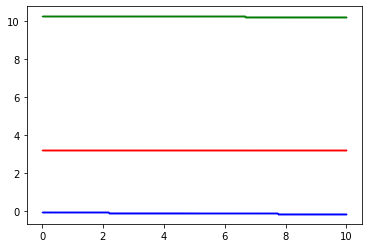

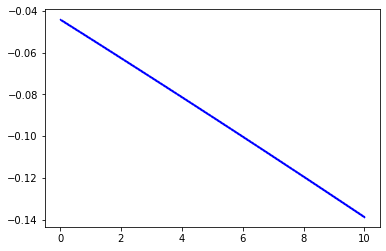

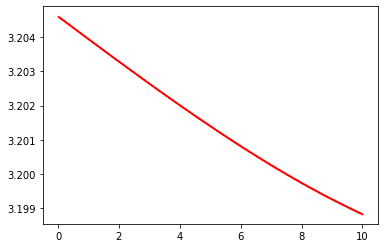

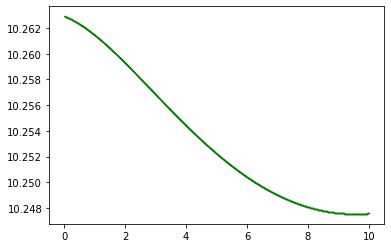

<Figure size 432x288 with 0 Axes>

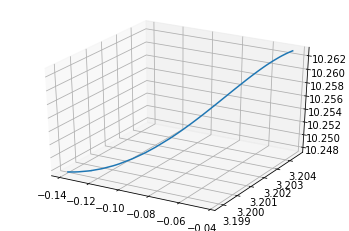

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkULEND_1000000_100_0.001_2022-04-21-03-11-55_1650513805_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkULEND_1000000_100_0.001_2022-04-21-03-11-55_1650513805_3D.png


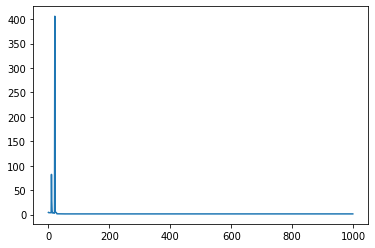

Epoch [01100/1000000] Loss:1.566088 Loss_1:1.498661 Loss_2:0.067418 Loss_3:0.000009 Lr:0.000476 Time:317.530892s (56.31min in total)
Epoch [01200/1000000] Loss:1.575400 Loss_1:1.498800 Loss_2:0.076591 Loss_3:0.000009 Lr:0.000455 Time:314.353445s (61.54min in total)


KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
# ULEND - Design A
# LBFGS version
main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigULEND
seed_max = 400
seed = choose_seed(seed_max)
print("Choosing seed {} (0~{})".format(seed, seed_max - 1))
model = SimpleNetworkULEND(config, seed).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
# CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=10)
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_ulend(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

In [ ]:
# ULEND - Design A
# LBFGS version
# cyclic learning-rate

from cyclic_lr_scheduler import CyclicLR


main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigULEND
seed_max = 400
seed = choose_seed(seed_max)
print("Choosing seed {} (0~{})".format(seed, seed_max - 1))
model = SimpleNetworkULEND(config, seed).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=10)
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_ulend(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

Output hidden; open in https://colab.research.google.com to view.

100%|██████████| 400/400 [01:02<00:00,  6.35it/s]


Choosing seed 36 (0~399)
using cuda
epoch = 1000000
epoch_step = 10
model_name = SimpleNetworkULEND
now_string = 2022-04-21-12-33-27
model_save_path_last = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkULEND_1000000_10_0.001_2022-04-21-12-33-27_last.pt
model_save_path_best = /content/drive/My Drive/Workspace/PINN/train/SimpleNetworkULEND_1000000_10_0.001_2022-04-21-12-33-27_best.pt
loss_save_path = /content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkULEND_1000000_10_0.001_2022-04-21-12-33-27_loss_1000000.npy
Epoch [00010/1000000] Loss:3.886325 Loss_1:3.858006 Loss_2:0.004377 Loss_3:0.023943 Lr:0.009010 Time:81.730983s (1.36min in total)
Epoch [00020/1000000] Loss:25.593163 Loss_1:14.675980 Loss_2:10.917183 Loss_3:0.000000 Lr:0.001090 Time:95.979949s (2.96min in total)
Epoch [00030/1000000] Loss:27.137020 Loss_1:14.663306 Loss_2:12.473714 Loss_3:0.000000 Lr:0.009010 Time:95.880830s (4.56min in total)
Epoch [00040/1000000] Loss:188987456.000000 Loss_1:5699.015625 Loss_2:

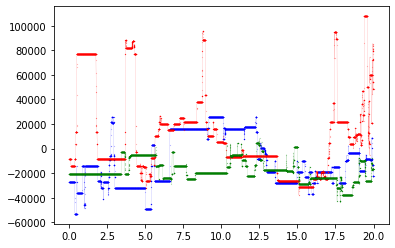

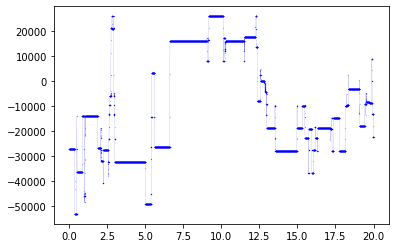

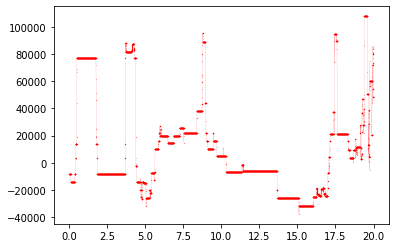

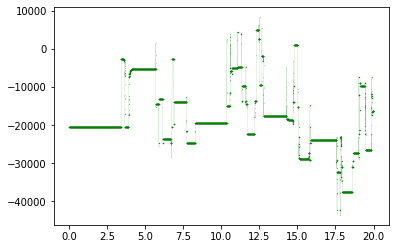

<Figure size 432x288 with 0 Axes>

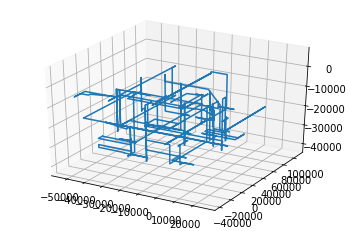

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkULEND_1000000_10_0.001_2022-04-21-12-33-27_1650553366_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkULEND_1000000_10_0.001_2022-04-21-12-33-27_1650553366_3D.png


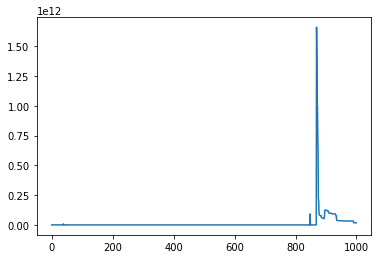

Epoch [01010/1000000] Loss:12088970240.000000 Loss_1:19009.316406 Loss_2:12088950784.000000 Loss_3:0.000000 Lr:0.009010 Time:45.656745s (149.00min in total)
Epoch [01020/1000000] Loss:11890739200.000000 Loss_1:19010.578125 Loss_2:11890719744.000000 Loss_3:0.000000 Lr:0.001090 Time:7.803991s (149.13min in total)
Epoch [01030/1000000] Loss:11864635392.000000 Loss_1:19009.789062 Loss_2:11864615936.000000 Loss_3:0.000000 Lr:0.009010 Time:8.201583s (149.27min in total)
Epoch [01040/1000000] Loss:11059097600.000000 Loss_1:17093.878906 Loss_2:11059080192.000000 Loss_3:0.000000 Lr:0.001090 Time:9.543892s (149.43min in total)
Epoch [01050/1000000] Loss:11057452032.000000 Loss_1:17093.941406 Loss_2:11057434624.000000 Loss_3:0.000000 Lr:0.009010 Time:7.911453s (149.56min in total)
Epoch [01060/1000000] Loss:11030145024.000000 Loss_1:17051.089844 Loss_2:11030127616.000000 Loss_3:0.000000 Lr:0.001090 Time:20.356566s (149.90min in total)
Epoch [01070/1000000] Loss:11027329024.000000 Loss_1:17051.089

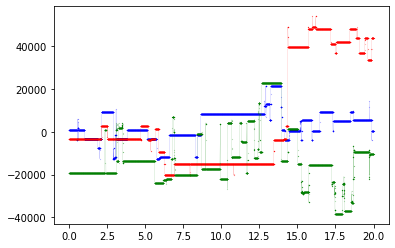

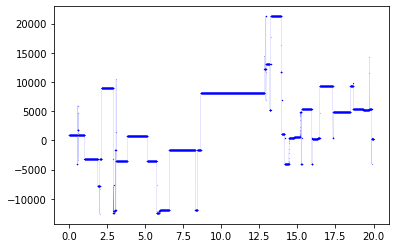

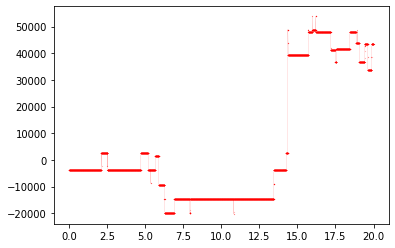

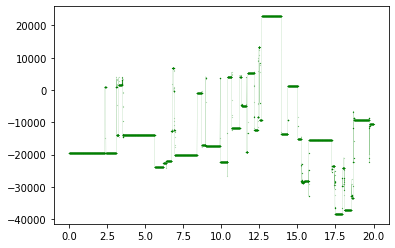

<Figure size 432x288 with 0 Axes>

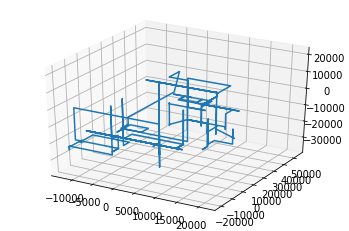

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkULEND_1000000_10_0.001_2022-04-21-12-33-27_1650555155_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkULEND_1000000_10_0.001_2022-04-21-12-33-27_1650555155_3D.png


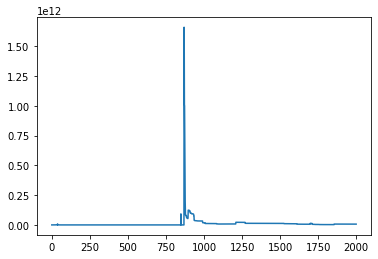

Epoch [02010/1000000] Loss:6643790848.000000 Loss_1:7950.052246 Loss_2:6643782656.000000 Loss_3:0.000000 Lr:0.009010 Time:5.159293s (178.14min in total)
Epoch [02020/1000000] Loss:6643702784.000000 Loss_1:7950.075195 Loss_2:6643694592.000000 Loss_3:0.000000 Lr:0.001090 Time:3.891332s (178.21min in total)
Epoch [02030/1000000] Loss:6643697152.000000 Loss_1:7950.076172 Loss_2:6643688960.000000 Loss_3:0.000000 Lr:0.009010 Time:2.938003s (178.26min in total)
Epoch [02040/1000000] Loss:6643678720.000000 Loss_1:7950.076172 Loss_2:6643670528.000000 Loss_3:0.000000 Lr:0.001090 Time:2.366425s (178.30min in total)
Epoch [02050/1000000] Loss:6642327552.000000 Loss_1:7948.739746 Loss_2:6642319360.000000 Loss_3:0.000000 Lr:0.009010 Time:7.709127s (178.42min in total)
Epoch [02060/1000000] Loss:6641647104.000000 Loss_1:7948.683105 Loss_2:6641638912.000000 Loss_3:0.000000 Lr:0.001090 Time:3.499843s (178.48min in total)
Epoch [02070/1000000] Loss:6641640448.000000 Loss_1:7948.683105 Loss_2:6641632256.

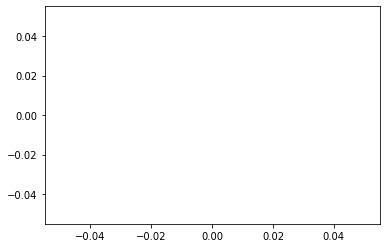

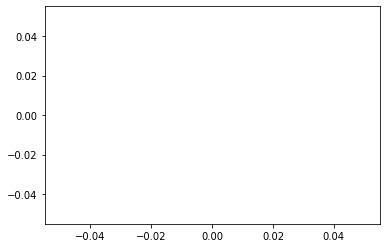

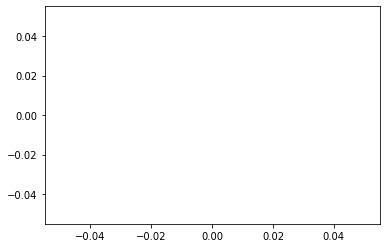

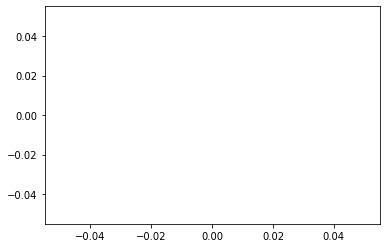

<Figure size 432x288 with 0 Axes>

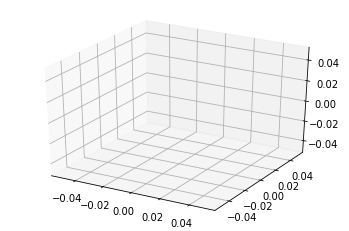

Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkULEND_1000000_10_0.001_2022-04-21-12-33-27_1650558095_2D.png
Saved as /content/drive/My Drive/Workspace/PINN/figure/SimpleNetworkULEND_1000000_10_0.001_2022-04-21-12-33-27_1650558095_3D.png


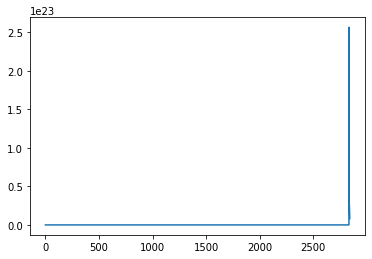

Epoch [03010/1000000] Loss:nan Loss_1:nan Loss_2:nan Loss_3:nan Lr:0.009010 Time:97.900925s (228.70min in total)
Epoch [03020/1000000] Loss:nan Loss_1:nan Loss_2:nan Loss_3:nan Lr:0.001090 Time:95.894149s (230.30min in total)
Epoch [03030/1000000] Loss:nan Loss_1:nan Loss_2:nan Loss_3:nan Lr:0.009010 Time:95.835898s (231.89min in total)
Epoch [03040/1000000] Loss:nan Loss_1:nan Loss_2:nan Loss_3:nan Lr:0.001090 Time:95.825860s (233.49min in total)
Epoch [03050/1000000] Loss:nan Loss_1:nan Loss_2:nan Loss_3:nan Lr:0.009010 Time:95.906608s (235.09min in total)
Epoch [03060/1000000] Loss:nan Loss_1:nan Loss_2:nan Loss_3:nan Lr:0.001090 Time:95.824779s (236.69min in total)
Epoch [03070/1000000] Loss:nan Loss_1:nan Loss_2:nan Loss_3:nan Lr:0.009010 Time:95.792379s (238.28min in total)
Epoch [03080/1000000] Loss:nan Loss_1:nan Loss_2:nan Loss_3:nan Lr:0.001090 Time:95.831060s (239.88min in total)
Epoch [03090/1000000] Loss:nan Loss_1:nan Loss_2:nan Loss_3:nan Lr:0.009010 Time:95.856256s (241

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [ ]:
# ULEND - Design A - t=20
# LBFGS version
# cyclic learning-rate

from cyclic_lr_scheduler import CyclicLR


main_path = "/content/drive/My Drive/Workspace/PINN"  # you may need to alter the path if it's not here
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = Args
if main_path:
    args.main_path = main_path
if not os.path.exists("{}/train".format(args.main_path)):
    os.makedirs("{}/train".format(args.main_path))
if not os.path.exists("{}/figure".format(args.main_path)):
    os.makedirs("{}/figure".format(args.main_path))
now_string = get_now_string()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = ConfigULEND
seed_max = 400
seed = choose_seed(seed_max)
print("Choosing seed {} (0~{})".format(seed, seed_max - 1))
model = SimpleNetworkULEND(config, seed).to(device)

model.train()
model_save_path_last = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_last.pt"
model_save_path_best = f"{args.main_path}/train/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_best.pt"
loss_save_path = f"{args.main_path}/loss/{model.model_name}_{args.epoch}_{args.epoch_step}_{args.lr}_{now_string}_loss_{args.epoch}.npy"


print("using " + str(device))
print("epoch = {}".format(args.epoch))
print("epoch_step = {}".format(args.epoch_step))
print("model_name = {}".format(model.model_name))
print("now_string = {}".format(now_string))
print("model_save_path_last = {}".format(model_save_path_last))
print("model_save_path_best = {}".format(model_save_path_best))
print("loss_save_path = {}".format(loss_save_path))
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
initial_lr = args.lr
# optimizer = optim.Adam(model.parameters(), lr = initial_lr)

# params = torch.nn.Parameter(1*torch.ones(1).to(device), requires_grad=True)

optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=100)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch/1000+1))
scheduler = CyclicLR(optimizer, base_lr=0.0001, max_lr=0.01, step_size=10)
# optimizer = optim.LBFGS(model.parameters(), lr=args.lr, max_iter=5000, max_eval=None, tolerance_grad=1e-05, tolerance_change=1e-09, history_size=100,
#       line_search_fn=None)
epoch_step = args.epoch_step
start_time = time.time()
start_time_0 = start_time

train_x = model.x
loss_record = []


for epoch in range(1, args.epoch + 1):
    # optimizer.zero_grad()
    # inputs = model.x
    # outputs = model(inputs)
    # u_hat, v_hat = torch.chunk(outputs, 2, 1)
    
    # Changes here
    loss, loss_list = model.loss()
    loss_1, loss_2, loss_3 = loss_list[0], loss_list[1], loss_list[2]
    # loss.backward()
    # optimizer.step()

    def closure():
        #optimizer.zero_grad()
        optimizer.zero_grad()
        output = model(train_x)
        l, loss_list = model.loss()
        l.backward()
        return l

    optimizer.step(closure)

    # options = {'closure': closure, 'current_loss': loss, 'max_ls': 10}

    scheduler.step()
    best_loss = 1e20
    loss_record.append(float(loss.item()))
    if epoch % epoch_step == 0:
        now_time = time.time()
        print("Epoch [{0:05d}/{1:05d}] Loss:{2:.6f} Loss_1:{3:.6f} Loss_2:{4:.6f} Loss_3:{5:.6f} Lr:{6:.6f} Time:{7:.6f}s ({8:.2f}min in total)".format(epoch, args.epoch, loss.item(), loss_1.item(), loss_2.item(), loss_3.item(), optimizer.param_groups[0]["lr"], time.time() - start_time, (now_time - start_time_0) / 60.0))
        start_time = now_time
        torch.save(
            {
                'epoch': args.epoch,
                'model_state_dict': model.state_dict(),
                # 'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss.item()
            }, model_save_path_last)
        # print(inputs.shape)
        if loss.item() < best_loss:
            torch.save(
                {
                    'epoch': args.epoch,
                    'model_state_dict': model.state_dict(),
                    # 'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss.item()
                }, model_save_path_best)
            best_loss = loss.item()
    if epoch % args.save_step == 0:
        test_ulend(model, args, config, now_string, True)
        draw_loss(np.asarray(loss_record))

num_parameter = -1  # get_model_parameters(model, config)
best_loss = best_loss
time_cost = (now_time - start_time_0) / 60.0
loss_record = np.asarray(loss_record)
np.save(loss_save_path, loss_record)

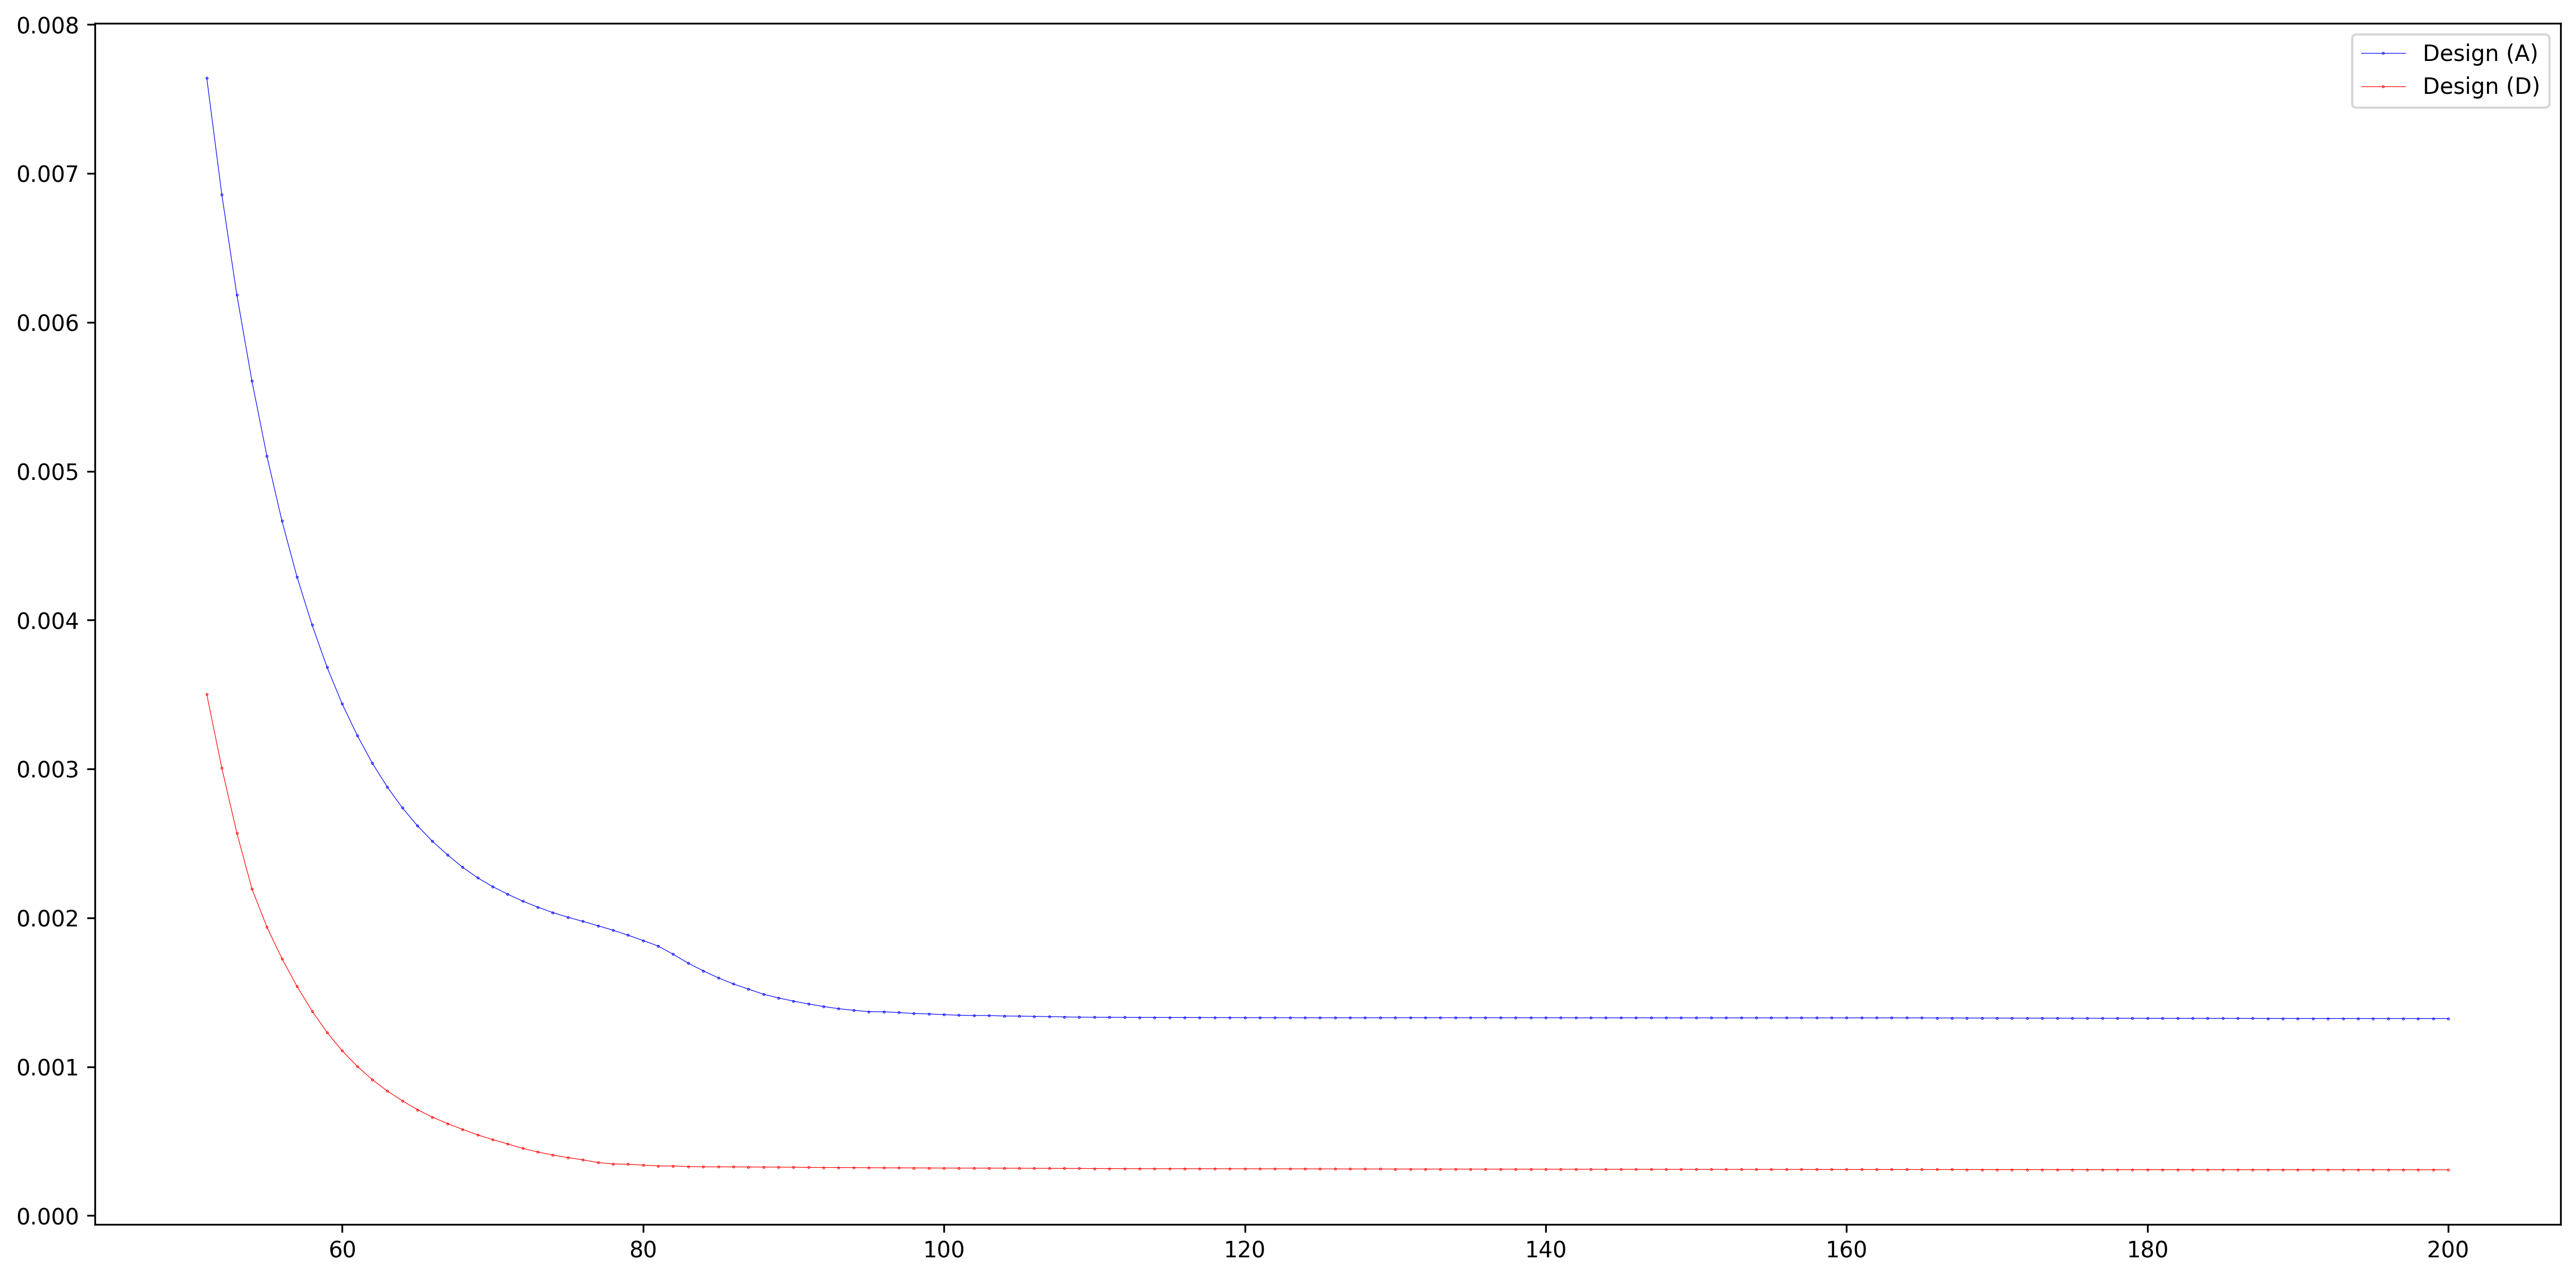

<Figure size 432x288 with 0 Axes>

In [ ]:
# loss
import numpy as np
loss_a = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-31-58_loss_200.npy")
loss_d = np.load("/content/drive/My Drive/Workspace/PINN/loss/SimpleNetworkSIS_200_10_0.001_0.4_0.04_2022-04-05-04-23-59_loss_200.npy")

start = 50
end = len(loss_a)
x = range(start + 1, end + 1)
plt.figure(dpi=300, figsize=[20,10])
plt.plot(x, loss_a[start:], marker='.', markersize=0.5, linewidth=0.3, c="b")
plt.plot(x, loss_d[start:], marker='.', markersize=0.5, linewidth=0.3, c="r")
plt.legend(["Design (A)","Design (D)"])
plt.show()
plt.clf()

0 [1. 1. 1.]
1 [1.01256574 1.25992001 0.98489104]
2 [1.04882146 1.52400084 0.97311434]
3 [1.1072063  1.79831458 0.9651591 ]
4 [1.18686548 2.08854554 0.96173738]
5 [1.2875548  2.4001604  0.96380622]
6 [1.4095688  2.7385521  0.97260828]
7 [1.55368879 3.109161   0.9897312 ]
8 [1.72114579 3.51757713 1.01718656]
9 [1.91359639 3.96962349 1.05751187]
10 [2.13310759 4.47142013 1.11389892]
11 [2.38214825 5.02942568 1.19035375]
12 [2.66358392 5.65045016 1.29189358]
13 [2.98067171 6.34162953 1.42478706]
14 [3.33705066 7.11034747 1.59684371]
15 [3.73672242 7.96408398 1.8177572 ]
16 [4.18401453 8.91016244 2.09950437]
17 [4.6835169  9.95535777 2.45679535]
18 [ 5.23997827 11.10531666  2.90755965]
19 [ 5.85814594 12.36372981  3.47343487]
20 [ 6.54252712 13.73118578  4.18019687]
21 [ 7.29704559 15.20363303  5.05802887]
22 [ 8.12456299 16.77038618  6.14146836]
23 [ 9.0262327  18.41165164  7.46879695]
24 [10.00065824 20.09563131  9.08055288]
25 [11.0428436  21.77541652 11.01677156]
26 [12.14295495 23.386

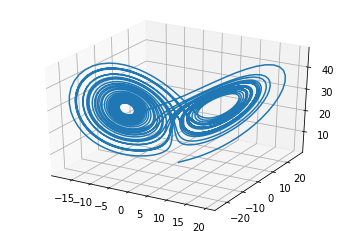

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 40.0, 0.01)

states = odeint(f, state0, t)
for index, item in enumerate(states):
  print(index, item)

fig = plt.figure()
ax = fig.gca(projection="3d")
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

In [ ]:
# seed = 99

# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)
# np.random.seed(seed)
# random.seed(seed)
# cudnn.deterministic = True
# print(np.random.rand(3,2))

import copy

def choose_seed(seed_max=100):
  record = []
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  config = ConfigULEND
  
  for seed in range(seed_max):
    # SimpleNetworkULEND.setup_seed(seed)
    w = torch.rand(3,5)
    # print(w)
    torch.nn.init.normal_(w, mean=0.0, std=1.0)
    model = SimpleNetworkULEND(config, seed).to(device)
    # print(model.state_dict)

    optimizer = optim.Adam(model.parameters(), lr = 0.001)
    model.train()
    optimizer.zero_grad()
    inputs = model.x
    outputs = model(inputs)
    loss, _ = model.loss()
    loss.backward()
    optimizer.step()


    loss, _ = model.loss()
    record.append([seed, loss.item()])
  record.sort(key=lambda x: x[1])
  # print(record)
  return record[0][0]

print(choose_seed(100))

RuntimeError: ignored

In [ ]:
lb_row = np.repeat(0, 3).reshape([1, -1])
ub_row = np.repeat(10, 3).reshape([1, -1])
x = lb_row + (ub_row - lb_row) * lhs(1, 10000)
x = sorted(x, key=lambda xx: xx[0])
print(x[:2], x[-2:])